# Satellite observations completeness for hydrological modelling

Production date: 12-07-2024

Produced by: Cristina Deidda (VUB)

## 🌍 Use case: Integrating satellite soil moisture data into catchment-scale hydrological models for flood prediction 

## ❓ Quality assessment question
* **Is the satellite soil moisture data sufficiently complete in spatial coverage to be considered suitable for integration into hydrological models?**


**Satellite soil moisture data can be used for different applications; one of the most common is hydrological models. The practice this analysis implies is the selection of a specific catchment area and the use of soil moisture data for each grid cell or averaging these values across the entire basin. For this type of application, it is essential to have a complete, or almost complete, data series in each cell. In this case study, we computed the percentage of missing values for each grid cell to highlight the completeness of data series and identify which areas may be more or less suitable for this purpose. From the results, we can see that the satellite soil moisture data are not complete, and the spatial completeness of the data varies by continent. Considering the time interval from 1997 to 2002, 37.7% of the world’s inland area has no data available. The coverage is better in Europe, South Africa and the continental US than some in other parts of the world, as well as the improvement in the availability of data as new sensors became available. While satellite soil moisture data have great potential for use as input in hydrological models, data availability and series completeness for the specific basin must be checked in advance.**


## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
* The completeness of satellite soil moisture data varies by continent.
* In areas with dense vegetation (tropical and boreal forests), strong topography (mountains), ice cover (Greenland, Antarctica, Himalayas), large fractional water coverage, or extreme desert regions, it is not possible to make meaningful soil moisture retrievals. Hence, they are masked (no data is available).
* Satellites follow paths that provide more coverage around the equator. In boreal (northern) and tropical regions, coverage is lower, which is expected due to high VOD (Vegetation Optical Depth) in these areas. Additionally, in far northern regions, snow and ice cover the ground for long periods, further reducing satellite coverage in these areas.
* Quality flags are available for daily data.
* Check the availability of data and the percentage of missing values before using it for hydrological applications.

```

Satellite data are not uniformly available in terms of both time and spatial coverage, with variations across continents. It is crucial to assess the completeness of the dataset for the specific area and timeframe under analysis before conducting any in-depth studies. In the specified time range of 1997-2002, approximately 37.8% of the world’s inland areas lack satellite data. Areas with dense vegetation (tropical and boreal forests), strong topography (mountains), ice cover (Greenland, Antarctica, Himalayas), large fractional water coverage, or extreme desert regions are masked since it was not possible to retrieve meaningful soil moisture data (see Section 1.5.3.3 of [PUGS](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355349314)). These areas are reported in gray in Figure 1.

Quality flags are provided for daily data, giving information for each pixel about: frozen soils, dense vegetation, no convergence in retrieval, physical bounds exceeded, weights of measurements below threshold, all datasets unreliable, and barren ground.

```{figure} attachment:1b0d321b-a063-402a-8480-54eb4d6e68c8.png
---
height: 150px
---
Figure1: Percentages of missing values at the global scale from 1997 to 2002. Areas in grey are masked.
```

The coverage is better in Europe, South Africa, and the continental US compared to other parts of the world, with improvements in data availability as new sensors became operational. Additionally, there is spatial variability in data availability among continents. For instance, the entire African continent has a 13% data gap, primarily concentrated in its central region, while South America exhibits a higher data deficiency, with 35.6% of its areas lacking data.

The product behaves as expected because satellites follow paths that provide more coverage around the equator. In the boreal (northern) and tropical regions, coverage is lower, which is expected due to high VOD (Vegetation Optical Depth) in these areas. Additionally, in far northern regions, snow and ice cover the ground for long periods, further reducing satellite coverage in these areas. These results refer to 'active' sensors and monthly aggregation. Similar results are found with mixed sensors for the period 2015-2020 (see Section 4.4 of [PQAD](https://confluence.ecmwf.int/pages/viewpage.action?pageId=371033706)).

Generally, for specific areas of the world, the dataset can be used for hydrological or modeling applications, such as isolating individual basins and studying soil moisture variations over time within the catchment area. We recommend conducting a preliminary pixel-level analysis to evaluate data completeness before beginning any detailed study. From the map, it is evident that certain regions of the globe possess more complete datasets, making them more suitable for this type of analysis than others.
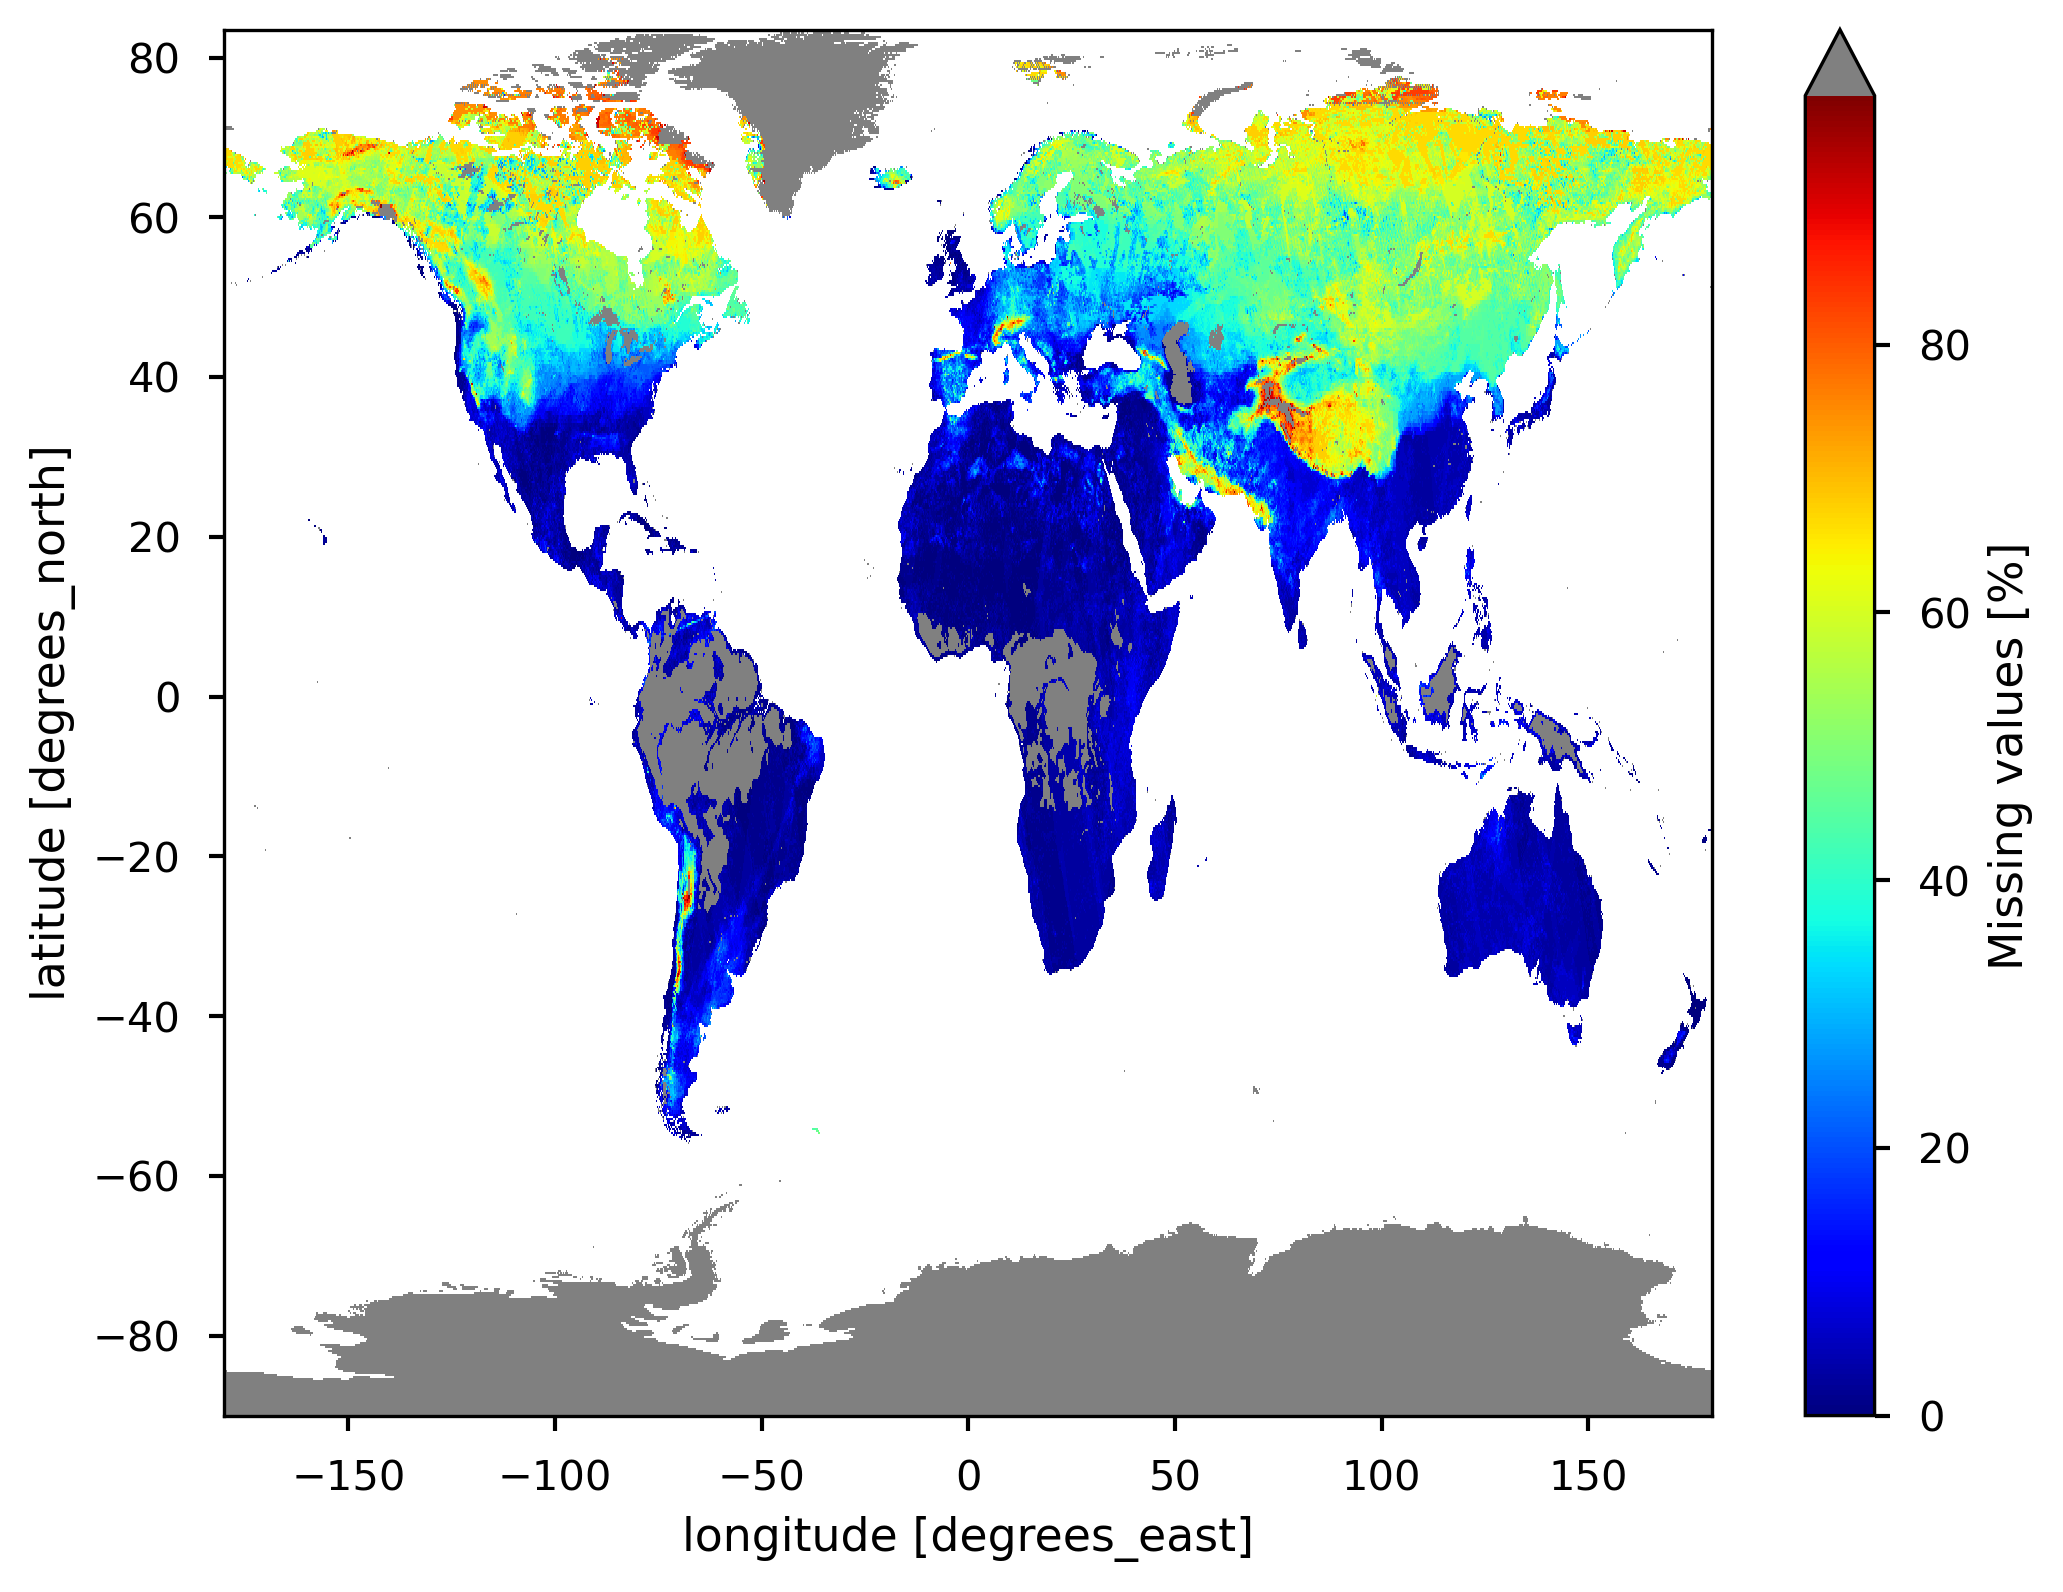

## 📋 Methodology
The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-1)**
 * Download surface soil moisture for the period 1997-2002.

**[](section-2)**
 * Calculating percentage of missing values for each pixel

**[](section-3)**
 * Plot a map showing the percentage of missing values for each pixel and for a selected continent.
 * Plot a histogram showing the percentage of missing values for the entire globe and for a selected continent.


## 📈 Analysis and results

(section-1)=
### 1. Data request and download

### Import packages

Import the packages to download the data using the c3s_eqc_automatic_quality_control library and the packages to clip the dataframe with shapefile to extract inland data (geopanda, shapely.geometry).


In [16]:
import fsspec
import os
import geopandas
import matplotlib.pyplot as plt
import shapely.geometry
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

### Set variables

Define the starting and ending year of the analysis. Donwload world shapefile.

In [17]:
year_start = 1997
year_stop = 2002

shapefile_url = "https://figshare.com/ndownloader/files/23392280"

### Set the data request

Set the data request for satellite soil moisture data, specifing the version and type of record required.

In [18]:
collection_id = "satellite-soil-moisture"
request = {
    "variable": "surface_soil_moisture",
    "type_of_sensor": "active",
    "time_aggregation": "month_average",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    "day": "01",
    "type_of_record": "cdr",
    "version": "v202212",
}

### Download data

Download the data.

In [19]:
# Dataset
ds = download.download_and_transform(
    collection_id,
    request,
    chunks={"year": 1},
    transform_chunks=False,
)


# Shapefile
with fsspec.open(f"simplecache::{shapefile_url}") as file:
    world_shape = geopandas.read_file(file)

100%|██████████| 6/6 [00:00<00:00, 15.66it/s]
/data/common/miniforge3/envs/wp5/lib/python3.11/site-packages/pyogrio/geopandas.py:261: UserWarning: More than one layer found in 'd2c24fc209d648fda09236af2bf7c708.zip': 'Continents' (default), 'Africa', 'North America', 'Europe', 'Oceania', 'South America', 'Asia', 'Antarctica', 'Australia'. Specify layer parameter to avoid this warning.
  result = read_func(


In [ ]:
# collapsable code cells - note that the code cell will be collapsed by the addition of a 'hide-input' tag when the Jupyter Book page is built

# code is included for transparency but also learning purposes and gives users the chance to adapt the code used for the assessment as they wish

(section-2)=
### 2. Define function to compute missing values count and plot


### Define missing values function

Function that calculate for each grid cell the number of NA values for the entire time period selected.

In [20]:
def compute_missing_values_count(ds):
    ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)

    da_mvc = ds["sm"].isnull().sum("time") / ds.sizes["time"] * 100
    da_mvc.attrs["long_name"] = "Missing values"
    da_mvc.attrs["units"] = "%"

    return da_mvc.to_dataset(name="mvc")

### Define plotting function

Define a plotting function to create a side-by-side visualization of a clipped world map and a histogram of missing values. The map displays missing values masked in gray, and the histogram shows the percentage of missing data.

In [22]:
def imshow_and_hist(da, shape):
    fig, (ax_imshow, ax_hist) = plt.subplots(
        1, 2, figsize=[10, 5], gridspec_kw={"width_ratios": [3, 2]}
    )
    cmap = plt.get_cmap("jet")
    cmap.set_over("gray")
    vmax = da.where(da < 100).max().values

    da = da.rio.clip(
        shape.geometry.apply(shapely.geometry.mapping),
        shape.crs,
        drop=True,
    )
    da.plot.imshow(ax=ax_imshow, cmap=cmap, vmax=vmax)
    ax_imshow.set_title("Map")

    da.where(da < 100).plot.hist(bins=50, ax=ax_hist)
    ax_hist.set_ylabel("Frequency")
    ax_hist.yaxis.set_label_position("right")
    ax_hist.yaxis.tick_right()

    # Compute and show no data percentage
    missing_data_perc = (da == 100).sum() / da.notnull().sum() * 100
    ax_hist.set_title(
        f"Percentage of area with missing data: {float(missing_data_perc):.2f} %"
    )

    fig.suptitle(", ".join(list(shape.CONTINENT)))
    return fig, (ax_imshow, ax_hist)

(section-3)=
## 3. Results visualization

### Plot world

Visualize on overview of the percentage of missing values for each pixel.

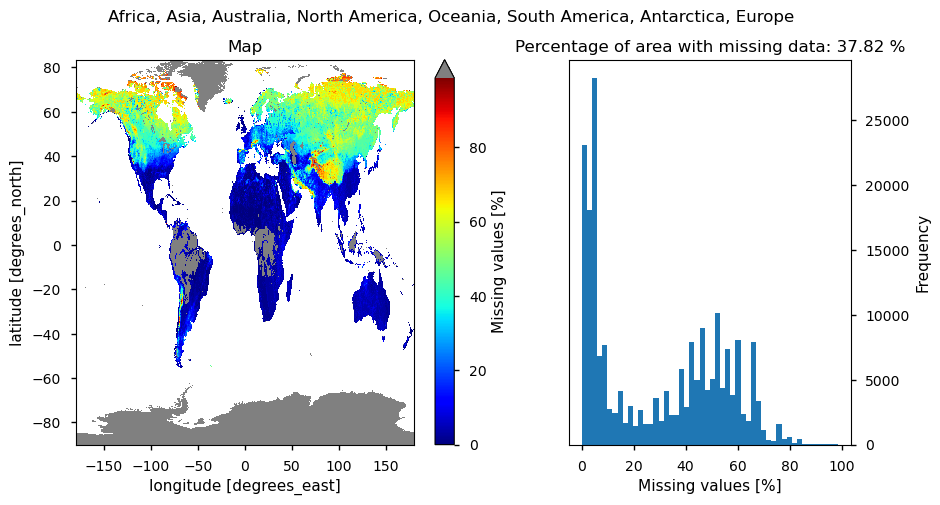

In [23]:
ds_misvalue= compute_missing_values_count(ds)
fig, axes = imshow_and_hist(ds_misvalue["mvc"], world_shape)

### Plot continents

Focus on a specific continent.

(<Figure size 1000x500 with 3 Axes>,
 (<Axes: title={'center': 'Map'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
  <Axes: title={'center': 'Percentage of area with missing data: 4.84 %'}, xlabel='Missing values [%]', ylabel='Frequency'>))

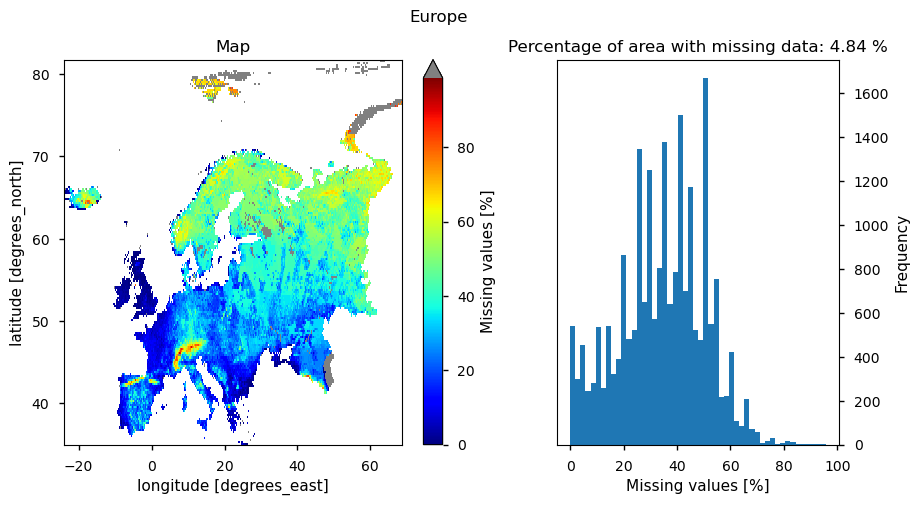

In [24]:
imshow_and_hist(ds_misvalue["mvc"], world_shape[world_shape.CONTINENT == "Europe"])

## ℹ️ If you want to know more

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

Dataset documentation:
* [PUGS](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355349314) 'Product User Guide and Specification'
* [PQAD](https://confluence.ecmwf.int/pages/viewpage.action?pageId=371033706) 'Product Quality Assurance Document'

